In [3]:
from pathlib import Path
import sys
import os
SPIKECOUNTER_PATH = os.getenv("SPIKECOUNTER_PATH")
sys.path.append(SPIKECOUNTER_PATH)

import matplotlib.pyplot as plt
from matplotlib import patches, lines
import matplotlib as mpl
import matplotlib.cm as cmaps
import matplotlib.colors as colors
from matplotlib import gridspec
import colorcet as cc
import re

from scipy import interpolate, signal, stats, optimize, ndimage
import scipy.io as scio
import numpy as np
import os
import skimage.io as skio
from skimage import measure, draw, transform, exposure

import pickle
import seaborn as sbs
from parse import *
import seaborn as sns

from spikecounter.analysis import traces, images
from spikecounter import utils
from spikecounter.ui import visualize
from spikecounter.analysis import stats as sc_stats
from sklearn import neighbors
import lmfit
from cycler import cycler
import pandas as pd
import importlib
from statannotations.Annotator import Annotator
pubstyle_path = os.path.join(os.getenv("SPIKECOUNTER_PATH"), "config", "bio_publications.mplstyle")
plt.style.use(
    pubstyle_path
)

In [4]:
output_datadir = Path(os.getenv("ANALYSIS_OUTPUT_ROOTDIR"), "2022 First Heartbeat_Submitted/Figures/Data/Figure5/gtacr_silencing")
os.makedirs(output_datadir, exist_ok=True)

In [5]:
all_data = pd.read_csv(output_datadir.parent/"gtacr_roi_data.csv")
embryo_data = pd.read_csv(output_datadir.parent/"gtacr_embryo_data.csv")

In [6]:
def generate_ratios(all_data):
    all_data["during_before_ratio_a"] = all_data["amplitude_during"]/all_data["amplitude_before"]
    all_data["during_before_ratio_f"] = all_data["freq_during"]/all_data["freq_before"]
    all_data["during_before_ratio_mf"] = all_data["median_freq_during"]/all_data["median_freq_before"]
    try:
        all_data["during_before_ratio_a_pk"] = all_data["pk_amp_during"]/all_data["pk_amp_before"]
        all_data["during_before_ratio_pf"] = all_data["pk_freq_during"]/all_data["pk_freq_before"]
        all_data["pwr_ratio_before_pk"] = all_data["amplitude_during"]/all_data["during_pwr_before_pk"]
    except Exception as e:
        pass

In [15]:
# generate_ratios(all_data)
# generate_ratios(embryo_data)
all_data["date"] = [re.search("\d+(?=_)", expt).group(0) for expt in all_data["expt"].tolist()]
embryo_data["date"] = [re.search("\d+(?=_)", expt).group(0) for expt in embryo_data["expt"].tolist()]

labels = list(all_data["roi"] == all_data["target"])
labels = ["+" if l else "-" for l in labels]
all_data["is_target"] = labels

### Selected data

old - 34 trials, new - 40 trials

In [8]:
keep_experiments = ["105213E4_silencing_target8_1V_OD0"] +\
["102209E16_silencing_target1","102002E16_silencing_target2",\
 "102551E16_silencing_target3", "112511E18_target1",\
 "113159E18_target3_1V", "113312E18_target3_0.7V",\
 "113430E18_target2_0.7V",\
 "115854E8_target3", "115726E8_target2", "120018E8_target2_2V"] + \
["113033gtacr_E4_target1", "114001gtacr_E4_target4_1V",\
"114120gtacr_E4_target2_1V", "114257gtacr_E4_target3_1V",\
 "114756gtacr_E4_target3_1.5V","120620gtacr_E3_target1_2V",\
 "120840gtacr_E3_target2_2V", "121100gtacr_E3_target3_2V"] + \
["095746E1_target1_1V", "100123E1_target2_1V",\
"104048E7_target1_3V", "104542E7_target2_3V", "104713E7_target3_3V",\
"112554E8_target1_2V","112920E8_target2_2V","113048_E8_target3_2V",\
"113205E8_target4_2V"] + \
 ["082618E3_silencing_target1", "085721E4_silencing_target2_1.5V",\
"085512E4_silencing_target1_1.5V","085834E4_silencing_target3_1.5V",\
"085954E4_silencing_target4_1.5V", "093238E6_target2", "093624E6_target4",\
"094631E7_target1", "094838E7_target2", "095017E7_target3", "095220E7_target4",\
"095345E7_target5"]

In [10]:
all_data.shape

(184, 39)

In [9]:
len(keep_experiments)

40

In [7]:
# discard_experiments = ["112800E18_target1_0.5V",
#             "115726E8_target2", "120205E8_target3_1V","120344E8_target3_2V",
#                 "120518E8_target3_0.5V","105012gtacr_E12_silencing_target1",
#             "105205gtacr_E12_silencing_target2",
#             "110025gtacr_E12_silencing_target4",
#             "113033gtacr_E4_target1",
#                 "114120gtacr_E4_target2_1V","114001gtacr_E4_target4_1V",
#             "114432gtacr_E4_target3_2V", "114756gtacr_E4_target3_1.5V", 
#             "120114gtacr_E3_target1", "120307gtacr_E3_target1_1.5V",
#                 "120439gtacr_E3_target1_1.75V",
#                       "121311gtacr_E3_target4_2V", "121436gtacr_E3_target5_2V",
#                 "121635gtacr_E3_target6_2V", "121944gtacr_E3_target7_2V",
#                       "093545E2_target1_silence", "093352E2_target1_silence",
#             "100727E1_target2_1.5V", "100922E1_target2_2V",
#             "103634E7_target1_2V", "103831E7_target1_2.5V",
#             "104320E7_target1_3.5V", "104930E7_target1and2_3V"]
# # "093754E2_target1_silence_4V"

In [11]:
selected_roi_data = all_data.loc[all_data[\
                    "file_name"].isin(keep_experiments)].copy().reset_index()
selected_embryo_data = embryo_data.loc[embryo_data[\
                    "file_name"].isin(keep_experiments)].copy().reset_index()
del(selected_roi_data["index"])
del(selected_embryo_data["index"])

In [8]:
loi_data = pd.read_csv(os.path.join(rootdir, "loi_measurements.csv"))
loi_by_expt = loi_data.set_index(["file_name", "silence"])
um_per_px = 0.265*4

In [9]:
selected_roi_data["dist_target_to_loi_before"] = np.nan
selected_roi_data["dist_target_to_loi_during"] = np.nan
selected_roi_data["loi_jump"] = np.nan
selected_embryo_data["dist_target_to_loi_before"] = np.nan
selected_embryo_data["dist_target_to_loi_during"] = np.nan
selected_embryo_data["loi_jump"] = np.nan


for i in range(selected_roi_data.shape[0]):
    xbefore, ybefore = loi_by_expt.loc[selected_roi_data.iloc[i\
                                    ]["file_name"],"before"][[\
                                        "loi_x_dv", "loi_y_dv"]]
    target_y, target_x = selected_roi_data.iloc[i][["target_y", "target_x"]]
    dist_before = ((target_y-ybefore)**2 + (target_x-xbefore)**2)**0.5*um_per_px
    xduring, yduring  = loi_by_expt.loc[selected_roi_data.iloc[i\
                                    ]["file_name"],"during"][[\
                                        "loi_x_dv", "loi_y_dv"]]
    dist_during = ((target_y-yduring)**2 + (target_x-xduring)**2)**0.5*um_per_px
    selected_roi_data.at[i, \
            "dist_target_to_loi_before"]=dist_before
    selected_roi_data.at[i, \
            "dist_target_to_loi_during"]=dist_during
    selected_roi_data.at[i, \
            "loi_jump"] = ((xduring-xbefore)**2 +\
                            (yduring-ybefore)**2)**0.5*um_per_px
    
for i in range(selected_embryo_data.shape[0]):
    fname = selected_embryo_data.iloc[i]["file_name"]
    xbefore, ybefore = loi_by_expt.loc[fname,"before"][[\
                                        "loi_x_dv", "loi_y_dv"]]
    target_y, target_x = selected_embryo_data.iloc[i][["target_y", "target_x"]]
    dist_before = ((target_y-ybefore)**2 + (target_x-xbefore)**2)**0.5*um_per_px
    xduring, yduring  = loi_by_expt.loc[fname,"during"][[\
                                        "loi_x_dv", "loi_y_dv"]]
    dist_during = ((target_y-yduring)**2 + (target_x-xduring)**2)**0.5*um_per_px
    selected_embryo_data.at[i, \
            "dist_target_to_loi_before"]=dist_before
    selected_embryo_data.at[i, \
            "dist_target_to_loi_during"]=dist_during
    selected_embryo_data.at[i, \
            "loi_jump"] = ((xduring-xbefore)**2 +\
                            (yduring-ybefore)**2)**0.5*um_per_px

(array([18., 23., 21., 25., 22., 28., 25., 12.,  2.,  3.]),
 array([0.        , 0.11582595, 0.2316519 , 0.34747785, 0.46330379,
        0.57912974, 0.69495569, 0.81078164, 0.92660759, 1.04243354,
        1.15825949]),
 <BarContainer object of 10 artists>)

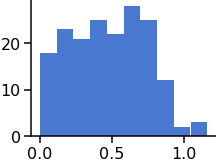

In [70]:
# plt.hist(, bins=np.linspace(0, 2, 100))
plt.hist(selected_roi_data["during_before_ratio_a_pk"])

In [17]:
print("Targeted ROIS: ", np.sum(selected_average_data["is_target"] == "+"))
print("Untargeted ROIS: ", np.sum(selected_average_data["is_target"] == "-"))

Targeted ROIS:  39
Untargeted ROIS:  140


<AxesSubplot:xlabel='target_dist', ylabel='during_before_ratio_a_pk'>

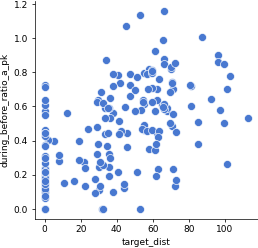

In [155]:
x = "target_dist"
y = "during_before_ratio_a_pk"
fig1, ax1 = plt.subplots(figsize=(4,4))
sns.scatterplot(data=selected_roi_data, x=x,y=y)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

- vs. +: Mann-Whitney-Wilcoxon test greater, P_val:7.525e-09 U_stat=4.350e+03


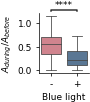

In [31]:
x = "is_target"
y = "during_before_ratio_a_pk"
cs = ["#DD7784", "#51779D"]
fig1, ax1 = plt.subplots(figsize=(1.5,1.7))
sns.boxplot(data=selected_roi_data, x=x, y=y,\
            ax=ax1, order=["-", "+"], palette = cs)
ax1.set_ylabel(r"$A_{during}/A_{before}$")
ax1.set_xlabel("Blue light")
# ax1.set_ylim(0, 1)
pairs = [("-", "+")]

annot = Annotator(ax1, pairs, data=selected_roi_data, x=x,y=y)
annot.configure(test="Mann-Whitney-gt", verbose=2, loc="outside")
annot.apply_and_annotate()
plt.tight_layout()
fig1.savefig(output_datadir/"illumination_amplitude_shift.svg", dpi=300, bbox_inches="tight")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

- vs. +: Mann-Whitney-Wilcoxon test greater, P_val:7.525e-09 U_stat=4.350e+03


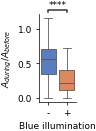

In [190]:
x = "is_target"
y = "during_before_ratio_a_pk"
fig1, ax1 = plt.subplots(figsize=(2*0.7,3*0.7))
sns.boxplot(data=selected_roi_data, x=x, y=y,\
            ax=ax1, order=["-", "+"])
ax1.set_ylabel(r"$A_{during}/A_{before}$")
ax1.set_xlabel("Blue illumination")
# ax1.set_ylim(0, 1)
pairs = [("-", "+")]

annot = Annotator(ax1, pairs, data=selected_roi_data, x=x,y=y)
annot.configure(test="Mann-Whitney-gt", verbose=2, loc="outside")
annot.apply_and_annotate()
plt.tight_layout()
plt.savefig(os.path.join(figdir, "Figure5", "illumination_amplitude_shift.svg"))

In [92]:
xdata = selected_average_data["target_dist"].to_numpy()
ydata = selected_average_data["during_before_ratio_a_pk"].to_numpy()
invalid = np.isnan(xdata) | np.isnan(ydata)
xdata = xdata[~invalid]
ydata = ydata[~invalid]
res = stats.linregress(xdata, ydata)


In [37]:
selected_roi_data.columns

Index(['roi', 'target', 'target_y', 'target_x', 'target_dist', 'area',
       'amplitude_before', 'amplitude_during', 'amplitude_after',
       'pk_amp_before', 'pk_amp_during', 'pk_amp_after', 'freq_before',
       'freq_during', 'freq_after', 'median_freq_before', 'median_freq_during',
       'median_freq_after', 'during_pwr_before_pk', 'after_pwr_before_pk',
       'pk_freq_before', 'pk_freq_during', 'pk_freq_after', 'embryo',
       'file_name', 'expt', 'during_before_ratio_a', 'during_before_ratio_f',
       'during_before_ratio_mf', 'during_before_ratio_a_pk',
       'during_before_ratio_pf', 'pwr_ratio_before_pk', 'date', 'is_target',
       'dist_target_to_loi_before', 'dist_target_to_loi_during', 'loi_jump'],
      dtype='object')

In [38]:
indexed_roi_data = selected_roi_data.set_index(["expt", "embryo", "target"])

In [43]:
indexed_roi_data["a_ratio_normalized"] = np.nan

In [ ]:
for expt, embryo, target in indexed_roi_data.index.unique():
    trial_roi_data = indexed_roi_data.loc[expt, embryo, target]
    target_mask = trial_roi_data["roi"].to_numpy() == target
    target_mask[np.argwhere(target_mask).ravel()[0]+1:] = False
    ref_value = trial_roi_data[target_mask]["during_before_ratio_a_pk"]
#     print(ref_value)
    trial_roi_data["a_ratio_normalized"] = trial_roi_data["during_before_ratio_a_pk"] - ref_value
#     print(indexed_roi_data.loc[expt,embryo,target])
#     norm_val = indexed_roi_data.loc[expt,embryo,target][["roi"] ==target]["during_before_ratio_a_pk"]
#     indexed_roi_data.loc[expt,embryo]["a_ratio"]

In [67]:
selected_roi_data = indexed_roi_data.reset_index()

LinregressResult(slope=0.004549115376198322, intercept=0.01567681060046458, rvalue=0.5480672399919515, pvalue=2.011215491520542e-15, stderr=0.0005218411194136654, intercept_stderr=0.02630166050642137)


Text(0.5, 0, 'Distance from illuminated spot ($\\mathrm{\\mu}$m)')

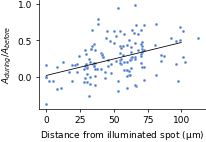

In [68]:
y="a_ratio_normalized"
x="target_dist"

xdata = selected_roi_data[x].to_numpy()
ydata = selected_roi_data[y].to_numpy()
valid = np.isfinite(xdata) & np.isfinite(ydata)
xdata = xdata[valid]
ydata = ydata[valid]
res = stats.linregress(xdata, ydata)
print(res)
xfit = np.linspace(0, 100, 100)
yfit = res.slope*xfit + res.intercept
fig1, ax1 = plt.subplots(figsize=(3,2))
sns.scatterplot(data=selected_roi_data, x=x, y=y,\
        ax=ax1, s=8)
ax1.plot(xfit, yfit, "k")
ax1.set_ylabel(r"$A_{during}/A_{before}$")
ax1.set_xlabel(r"Distance from illuminated spot ($\mathrm{\mu}$m)")

LinregressResult(slope=0.004870224040040903, intercept=0.2709068295054128, rvalue=0.5416857701865568, pvalue=4.8811503675722056e-15, stderr=0.0005680603571999453, intercept_stderr=0.028631186977018743)


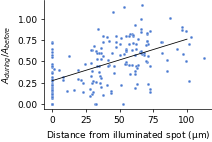

In [215]:
y="during_before_ratio_a_pk"
x="target_dist"

xdata = selected_roi_data[x].to_numpy()
ydata = selected_roi_data[y].to_numpy()
valid = np.isfinite(xdata) & np.isfinite(ydata)
xdata = xdata[valid]
ydata = ydata[valid]
res = stats.linregress(xdata, ydata)
print(res)
xfit = np.linspace(0, 100, 100)
yfit = res.slope*xfit + res.intercept
fig1, ax1 = plt.subplots(figsize=(3,2))
sns.scatterplot(data=selected_roi_data, x=x, y=y,\
        ax=ax1, s=8)
ax1.plot(xfit, yfit, "k")
ax1.set_ylabel(r"$A_{during}/A_{before}$")
ax1.set_xlabel(r"Distance from illuminated spot ($\mathrm{\mu}$m)")
plt.savefig(os.path.join(figdir, "Figure4", "amplitude_vs_distance_from_illum.svg"))

In [213]:
selected_roi_data.columns

Index(['roi', 'target', 'target_y', 'target_x', 'target_dist', 'area',
       'amplitude_before', 'amplitude_during', 'amplitude_after',
       'pk_amp_before', 'pk_amp_during', 'pk_amp_after', 'freq_before',
       'freq_during', 'freq_after', 'median_freq_before', 'median_freq_during',
       'median_freq_after', 'during_pwr_before_pk', 'after_pwr_before_pk',
       'pk_freq_before', 'pk_freq_during', 'pk_freq_after', 'embryo',
       'file_name', 'expt', 'during_before_ratio_a', 'during_before_ratio_f',
       'during_before_ratio_mf', 'during_before_ratio_a_pk',
       'during_before_ratio_pf', 'pwr_ratio_before_pk', 'date', 'is_target',
       'dist_target_to_loi_before', 'dist_target_to_loi_during', 'loi_jump'],
      dtype='object')

In [210]:
np.argsort(-selected_roi_data["during_before_ratio_a"])

0        4
1       34
2       32
3       60
4       62
      ... 
179    166
180    182
181    177
182    153
183    152
Name: during_before_ratio_a, Length: 184, dtype: int64

LinregressResult(slope=0.005016267622579659, intercept=0.7543430436443762, rvalue=0.3637217732928255, pvalue=0.02283860277591652, stderr=0.0021120147889307373, intercept_stderr=0.10672330725247428)


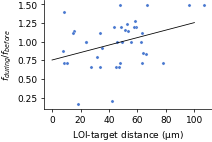

In [206]:
y="during_before_ratio_mf"
x="dist_target_to_loi_before"
xdata = selected_embryo_data[x].to_numpy()
ydata = selected_embryo_data[y].to_numpy()
valid = np.isfinite(xdata) & np.isfinite(ydata)
xdata = xdata[valid]
ydata = ydata[valid]
res = stats.linregress(xdata, ydata)
print(res)
xfit = np.linspace(0, 100, 100)
yfit = res.slope*xfit + res.intercept
fig1, ax1 = plt.subplots(figsize=(3,2))
sns.scatterplot(data=selected_embryo_data, x=x, y=y,\
        ax=ax1, s=10)
ax1.plot(xfit, yfit, "k")
ax1.set_ylabel(r"$f_{during}/f_{before}$")
ax1.set_xlabel(r"LOI-target distance ($\mathrm{\mu}$m)")
plt.savefig(os.path.join(figdir, "Figure4", "silencing_frequency_loi_distance.svg"))

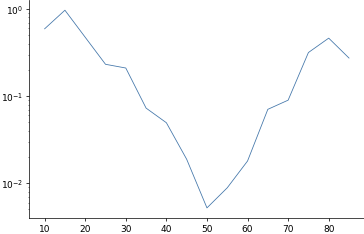

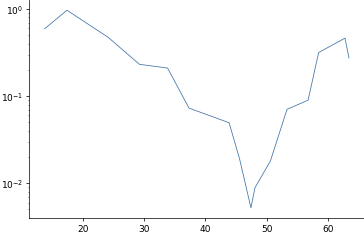

In [16]:
quantiles = np.arange(10, 90, step=5)
x = "dist_target_to_loi_before"
y = "during_before_ratio_mf"
p = np.zeros_like(quantiles, dtype=float)

ts = np.zeros_like(quantiles, dtype=float)
for idx, q in enumerate(quantiles):
    threshold = np.nanpercentile(selected_embryo_data[x], q)
    mask = selected_embryo_data[x] < threshold
    a = selected_embryo_data[mask][y].to_numpy()
    b = selected_embryo_data[~mask][y].to_numpy()
    res = stats.mannwhitneyu(a, b)
    p[idx] = res.pvalue
    ts[idx] = threshold
fig1, ax1 = plt.subplots(figsize=(6,4))
ax1.plot(quantiles, p)
ax1.set_yscale("log")
fig1, ax1 = plt.subplots(figsize=(6,4))
ax1.plot(ts, p)
ax1.set_yscale("log")

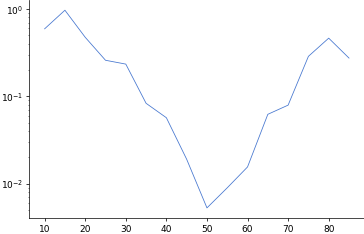

In [17]:
threshold = np.nanpercentile(selected_embryo_data["dist_target_to_loi_before"], 50)
loi_target = selected_embryo_data["dist_target_to_loi_before"] < threshold
print("n expts LOI targeted: ", np.sum(selected_embryo_data["dist_target_to_loi_before"] < threshold))
labels = ["LOI" if l else "Not LOI" for l in loi_target]
selected_embryo_data["loi_target"] = labels

n expts LOI targeted:  19


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

LOI vs. Not LOI: Mann-Whitney-Wilcoxon test two-sided, P_val:7.725e-03 U_stat=9.500e+01


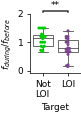

In [28]:
plt.style.use(pubstyle_path)
x="loi_target"
y="during_before_ratio_f"
fig1, ax1 = plt.subplots(figsize=(1.5,1.85))
order  = ["Not LOI", "LOI"]
# arr1 = selected_embryo_data[selected_embryo_data[x] == order[0]][y]
# arr2 = selected_embryo_data[selected_embryo_data[x] == order[0]][y]
# ax1.boxplot([arr1, arr2])

cs = [np.array([0,204,0,255])/255, np.array([121,67,142,255])/255]
sns.boxplot(data=selected_embryo_data, x=x, y=y,ax=ax1, order=order,boxprops={
        "facecolor": "w",
})
sns.swarmplot(data=selected_embryo_data, x=x, y=y,ax=ax1, order=order, palette = cs,
    dodge = True, size=3)
ax1.set_ylim(-0.1, 2)
ax1.set_xlabel("Target")
ax1.set_xticklabels(["Not\nLOI", "LOI"])
ax1.set_ylabel(r"$f_{during}/f_{before}$")
pairs = [("Not LOI", "LOI")]
# for patch, color in zip(bplot['boxes'], cs):
#     patch.set_facecolor(color)

annot = Annotator(ax1, pairs, data=selected_embryo_data, x=x,y=y)
annot.configure(test="Mann-Whitney", verbose=2, loc="outside")
annot.apply_and_annotate()
plt.tight_layout()
fig1.savefig(output_datadir/"frequency_loi_silencing.svg", dpi=300, bbox_inches="tight")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

LOI vs. Not LOI: Mann-Whitney-Wilcoxon test two-sided, P_val:1.995e-03 U_stat=3.005e+02


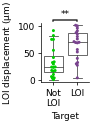

In [30]:
plt.style.use(pubstyle_path)
x="loi_target"
y="loi_jump"
fig1, ax1 = plt.subplots(figsize=(1.5,1.85))
order  = ["Not LOI", "LOI"]
# arr1 = selected_embryo_data[selected_embryo_data[x] == order[0]][y]
# arr2 = selected_embryo_data[selected_embryo_data[x] == order[0]][y]
# ax1.boxplot([arr1, arr2])

cs = [np.array([0,204,0,255])/255, np.array([121,67,142,255])/255]
sns.boxplot(data=selected_embryo_data, x=x, y=y,ax=ax1, order=order,boxprops={
        "facecolor": "w",
}, fliersize=0)
sns.swarmplot(data=selected_embryo_data, x=x, y=y,ax=ax1, order=order, palette = cs,
    dodge = True, size=3)
# ax1.set_ylim(-0.1, 2)
ax1.set_xlabel("Target")
ax1.set_xticklabels(["Not\nLOI", "LOI"])
ax1.set_ylabel(r"LOI displacement ($\mathrm{\mu}$m)")
pairs = [("Not LOI", "LOI")]
# for patch, color in zip(bplot['boxes'], cs):
#     patch.set_facecolor(color)

annot = Annotator(ax1, pairs, data=selected_embryo_data, x=x,y=y)
annot.configure(test="Mann-Whitney", verbose=2, loc="outside")
annot.apply_and_annotate()
plt.tight_layout()
fig1.savefig(output_datadir/"displacement_loi_silencing.svg", dpi=300, bbox_inches="tight")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

LOI vs. Not LOI: Mann-Whitney-Wilcoxon test two-sided, P_val:1.995e-03 U_stat=3.005e+02


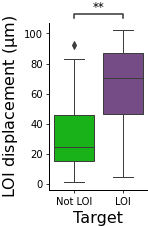

In [70]:
with plt.style.context("../bio_pubs_presentation.mplstyle"):
    x="loi_target"
    y="loi_jump"
    fig1, ax1 = plt.subplots(figsize=(2.4,3.5))
    cs = [np.array([0,204,0,255])/255, np.array([121,67,142,255])/255]
    sns.boxplot(data=selected_embryo_data, x=x, y=y,ax=ax1, order=["Not LOI", "LOI"], palette=cs)
#     ax1.set_ylim(-0.1, 2)
    ax1.set_xlabel("Target")
    ax1.set_ylabel(r"LOI displacement ($\mathrm{\mu}$m)")

    pairs = [("Not LOI", "LOI")]

    annot = Annotator(ax1, pairs, data=selected_embryo_data, x=x,y=y)
    annot.configure(test="Mann-Whitney", verbose=2, loc="outside")
    annot.apply_and_annotate()
    plt.tight_layout()
    plt.savefig(os.path.join(figdir, "Figure4", "POSTER_loi_jump_median.svg"))

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

LOI vs. Not LOI: Mann-Whitney-Wilcoxon test two-sided, P_val:1.995e-03 U_stat=3.005e+02


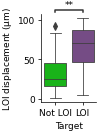

In [35]:
x="loi_target"
y="loi_jump"
fig1, ax1 = plt.subplots(figsize=(2*0.8,3*0.7))
order  = ["Not LOI", "LOI"]
# arr1 = selected_embryo_data[selected_embryo_data[x] == order[0]][y]
# arr2 = selected_embryo_data[selected_embryo_data[x] == order[0]][y]
# ax1.boxplot([arr1, arr2])

cs = [np.array([0,204,0,255])/255, np.array([121,67,142,255])/255]
sns.boxplot(data=selected_embryo_data, x=x, y=y,ax=ax1, order=["Not LOI", "LOI"], palette=cs)

ax1.set_xlabel("Target")
ax1.set_ylabel(r"LOI displacement ($\mathrm{\mu}$m)")

pairs = [("Not LOI", "LOI")]

annot = Annotator(ax1, pairs, data=selected_embryo_data, x=x,y=y)
annot.configure(test="Mann-Whitney", verbose=2, loc="outside")
annot.apply_and_annotate()
plt.tight_layout()
plt.savefig(os.path.join(figdir, "Figure4", "loi_position_shift_median.svg"))

In [ ]:
x="loi_target"
y="loi_jump"
fig1, ax1 = plt.subplots(figsize=(2*0.8,3*0.7))
order  = ["Not LOI", "LOI"]
# arr1 = selected_embryo_data[selected_embryo_data[x] == order[0]][y]
# arr2 = selected_embryo_data[selected_embryo_data[x] == order[0]][y]
# ax1.boxplot([arr1, arr2])

cs = [np.array([0,204,0,255])/255, np.array([121,67,142,255])/255]
sns.boxplot(data=selected_embryo_data, x=x, y=y,ax=ax1, order=["Not LOI", "LOI"], palette=cs)

pairs = [("Not LOI", "LOI")]

annot = Annotator(ax1, pairs, data=selected_embryo_data, x=x,y=y)
annot.configure(test="Mann-Whitney", verbose=2, loc="outside")
annot.apply_and_annotate()
plt.tight_layout()
plt.savefig(os.path.join(figdir, "Figure4", "loi_position_shift_median.svg"))

LinregressResult(slope=-0.6280345928099884, intercept=77.73613398171219, rvalue=-0.4505562540063519, pvalue=0.0039977550658849385, stderr=0.2045797231411027, intercept_stderr=10.337723374308268)


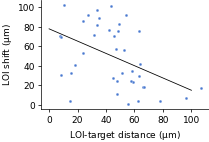

In [227]:
y="loi_jump"
x="dist_target_to_loi_before"
xdata = selected_embryo_data[x].to_numpy()
ydata = selected_embryo_data[y].to_numpy()
invalid = np.isnan(xdata) | np.isnan(ydata)
xdata = xdata[~invalid]
ydata = ydata[~invalid]
res = stats.linregress(xdata, ydata)
fig1, ax1 = plt.subplots(figsize=(3,2))
sns.scatterplot(data=selected_embryo_data, x=x, y=y,\
        ax=ax1, s=8)
ax1.set_ylabel(r"LOI shift ($\mathrm{\mu}$m)")
ax1.set_xlabel(r"LOI-target distance ($\mathrm{\mu}$m)")
xfit = np.linspace(0, 100, 100)
yfit = res.slope*xfit + res.intercept
plt.plot(xfit, yfit, color="k")
# ax1.set_ylim((0,1))
print(res)
plt.savefig(os.path.join(figdir, "Figure4", "LOI_shift_vs_target_distance.svg"))

### Plot with bins by LOI-target distance

In [236]:
bin_edges = np.nanpercentile(unique_expt_data["dist_target_to_loi_before"], np.linspace(0,100,7))

In [237]:
bin_edges

array([  7.76413094,  20.20550368,  34.76078348,  47.43854275,
        54.19818842,  63.06687137, 106.90590574])

In [238]:
# bin_edges = [0,15,25,35,45,48,55,60,65,100]
xs = [(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]
bin_dfs = []
for idx in range(len(bin_edges)-1):
    loi_target_dist = selected_average_data["dist_target_to_loi_before"]
    mask = (loi_target_dist < bin_edges[idx+1]) & (loi_target_dist >= bin_edges[idx])
    bin_dfs.append(selected_average_data[mask])
    

[7, 6, 6, 7, 6, 6]


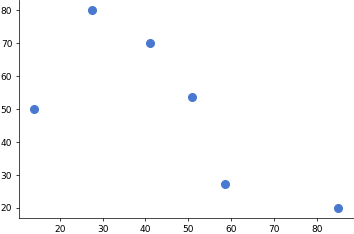

In [239]:
ys = []
n_samples = []
fig1, ax1 = plt.subplots(figsize=(6,4))
for bdf in bin_dfs:
    unique_bdf = bdf[bdf["roi"] == bdf["target"]]
    ys.append(np.nanmean(unique_bdf["loi_jump"].to_numpy()))
    n_samples.append(unique_bdf.shape[0])
ax1.scatter(xs, ys)
print(n_samples)

In [226]:
np.sum(n_samples)

38

[25, 20, 27, 21, 23, 25]


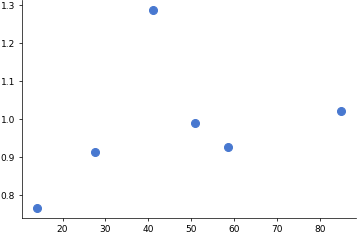

In [240]:
ys = []
n_samples = []
fig1, ax1 = plt.subplots(figsize=(6,4))
for bdf in bin_dfs:
    unique_bdf = bdf[bdf["roi"] != bdf["target"]]
    ys.append(np.nanmean(unique_bdf["during_before_ratio_f"].to_numpy()))
    n_samples.append(unique_bdf.shape[0])
ax1.scatter(xs, ys)
print(n_samples)

### Dynamic calculation of LOI

In [265]:
all_data

,roi,target,target_y,target_x,target_dist,area,amplitude_before,amplitude_during,amplitude_after,pk_amp_before,...,embryo,file_name,expt,during_before_ratio_a_pk,during_before_ratio_a,during_before_ratio_f,during_before_ratio_mf,pwr_ratio_before_pk,date,is_target
0,0.0,0,100.025658,106.522219,0.000000,9159.0,13.391149,0.006420,18.432469,0.016255,...,4,102247E4_silencing_4V_OD0_target1,20220212_gtacr_targeted_silencing,0.044005,0.000479,0.173570,2.603556,12.794441,20220212,+
1,1.0,0,100.025658,106.522219,4.086872,768.0,220.774979,1.284266,244.392157,0.060976,...,4,102247E4_silencing_4V_OD0_target1,20220212_gtacr_targeted_silencing,0.025690,0.005817,0.086785,0.086785,509.888827,20220212,-
2,2.0,0,100.025658,106.522219,35.367870,1109.0,80.010854,1.024239,116.215700,0.040053,...,4,102247E4_silencing_4V_OD0_target1,20220212_gtacr_targeted_silencing,0.074426,0.012801,0.086785,0.173570,30.034549,20220212,-
3,3.0,0,100.025658,106.522219,34.478410,1065.0,73.391431,0.043826,60.612920,0.036510,...,4,102247E4_silencing_4V_OD0_target1,20220212_gtacr_targeted_silencing,0.056807,0.000597,0.260356,3.905334,10.385804,20220212,-
4,4.0,0,100.025658,106.522219,102.297811,629.0,3.011911,0.680838,2.444909,0.000521,...,4,102247E4_silencing_4V_OD0_target1,20220212_gtacr_targeted_silencing,1.778648,0.226048,1.388563,1.388563,1.000000,20220212,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,0.0,4,143.203947,133.457237,44.467886,300.0,126.449434,32.677287,87.496545,0.082782,...,8,113317E8_target5_2V,20220407_gtacr_silencing,0.829918,0.258422,1.202590,1.030792,1.441227,20220407,-
556,1.0,4,143.203947,133.457237,57.358866,300.0,41.927954,15.990084,36.642881,0.056570,...,8,113317E8_target5_2V,20220407_gtacr_silencing,0.886962,0.381370,1.202590,1.030792,1.504457,20220407,-
557,2.0,4,143.203947,133.457237,23.972034,293.0,37.871040,5.801575,28.078298,0.048043,...,8,113317E8_target5_2V,20220407_gtacr_silencing,0.632413,0.153193,0.858993,1.202590,1.132383,20220407,-
558,3.0,4,143.203947,133.457237,33.324597,293.0,102.899934,20.363615,71.367684,0.074724,...,8,113317E8_target5_2V,20220407_gtacr_silencing,0.713255,0.197897,1.202590,1.202590,1.369965,20220407,-


In [362]:
selected_average = selected_average.set_index("file_name")

In [363]:
target_to_loi = []
selected_average["dist_target_to_loi"] = np.nan
for i in range(all_data.shape[0]):
    try:
        loi_x, loi_y = loi_by_expt.loc[all_data.iloc[i]["file_name"], "before"][["loi_x_dv", "loi_y_dv"]]
        target_y, target_x = all_data.iloc[i][["target_y", "target_x"]]
        dist = ((target_y-loi_y)**2 + (target_x-loi_x)**2)**0.5
        target_to_loi.append(dist)
        if all_data.iloc[i]["file_name"] in list(selected_average.index.unique()):
            selected_average.at[all_data.iloc[i]["file_name"], "dist_target_to_loi"]=dist
    except Exception as e:
        print(e)
        target_to_loi.append(np.nan)
all_data["dist_target_to_loi"] = target_to_loi

'105530E4_silencing_target9_1V_OD0_10Hz'
'105530E4_silencing_target9_1V_OD0_10Hz'
'105530E4_silencing_target9_1V_OD0_10Hz'
'105530E4_silencing_target9_1V_OD0_10Hz'
'105530E4_silencing_target9_1V_OD0_10Hz'
'105530E4_silencing_target9_1V_OD0_10Hz'
'105530E4_silencing_target9_1V_OD0_10Hz'
'105530E4_silencing_target9_1V_OD0_10Hz'
'105530E4_silencing_target9_1V_OD0_10Hz'
'105530E4_silencing_target9_1V_OD0_10Hz'
'105530E4_silencing_target9_1V_OD0_10Hz'
'before'
'before'
'before'
'before'
'before'
'before'
'before'
'before'
'before'
'before'
'before'
'105857E4_silencing_target10_2V_OD0_10Hz'
'105857E4_silencing_target10_2V_OD0_10Hz'
'105857E4_silencing_target10_2V_OD0_10Hz'
'105857E4_silencing_target10_2V_OD0_10Hz'
'105857E4_silencing_target10_2V_OD0_10Hz'
'105857E4_silencing_target10_2V_OD0_10Hz'
'105857E4_silencing_target10_2V_OD0_10Hz'
'105857E4_silencing_target10_2V_OD0_10Hz'
'105857E4_silencing_target10_2V_OD0_10Hz'
'105857E4_silencing_target10_2V_OD0_10Hz'
'105857E4_silencing_target10_2

In [274]:
for expt, embryo_dict in loi_targets_by_expt_embryo.items():
    data_single_expt = all_data_by_expt_embryo.loc[expt]
    for embryo, loi_target in embryo_dict.items():
        embryo_data = data_single_expt.loc[embryo].copy()
        embryo_data["loi_target"] = embryo_data["target"] == loi_target
        selected_embryo_data.append(embryo_data.reset_index())
selected_data = pd.concat(selected_embryo_data, axis=0)

In [326]:
threshold = 55
selected_data["loi_target"] = ["+" if l else "-" for l in \
                selected_data["dist_target_to_loi"] < threshold]
selected_average["loi_target"] = ["+" if l else "-" for l in \
                selected_average["dist_target_to_loi"] < threshold]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

- vs. +: Mann-Whitney-Wilcoxon test smaller, P_val:8.097e-01 U_stat=2.600e+02


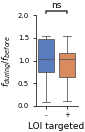

In [327]:
x="loi_target"
y="during_before_ratio_f"
fig1, ax1 = plt.subplots(figsize=(2*0.7,3*0.7))
sns.boxplot(data=selected_average, x=x, y=y,ax=ax1, order=["-", "+"])
# sns.swarmplot(data=freq_ratio_filtered, x="loi_target", y="during_before_ratio_mf", hue="is_target", ax=ax1)
ax1.set_ylim(0, 2)
ax1.set_xlabel("LOI targeted")
ax1.set_ylabel(r"$f_{during}/f_{before}$")

pairs = [("-", "+")]

annot = Annotator(ax1, pairs, data=selected_average, x=x,y=y)
annot.configure(test="Mann-Whitney-ls", verbose=2, loc="outside")
annot.apply_and_annotate()
plt.tight_layout()
# plt.savefig(os.path.join(figdir, "Figure4", "freq_shift_loi_embryo_mean_dynamic.svg"))